# A Predictive Model of Fraud Using a Random Forest Classifier and a Little Blood, Sweat and Tears. 
### Here, I used Random Forests (RFs) for a few reasons. For one, there are both numerical and categorical covariates in the analysis. Knowing the flexibility and ease of implementation of RFs in this scenario, it fits well into the picture. 
By: Aaron J. Kelly

Date: 3/11/2017

In [4]:
import numpy as np
import scipy as sp
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import math
from sklearn import ensemble as e
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as enc
from sklearn.preprocessing import LabelEncoder as lab
import datetime as dt

### Read in data and sanity check it. 

In [5]:
# Read data into notebook as pandas dataframe
fraud = pd.read_csv('Data Challenges/Fraud/Fraud_Data.csv')
ips = pd.read_csv('Data Challenges/Fraud/IpAddress_to_Country.csv')
## Look at the fraud data to make sure it got read in right. 
print 'The dimensions of fraud are ' + str(fraud.shape) + '.'
for i in fraud.columns.tolist():
    print 'There are a total of ' + str(len(np.unique(fraud[i]))) + ' unique values in column ' + i
print str(100*sum(fraud['class'])/float(len(fraud['class']))) + '% of the first transactions were fraudulent in the data.'
fraud.head()

The dimensions of fraud are (151112, 11).
There are a total of 151112 unique values in column user_id
There are a total of 151112 unique values in column signup_time
There are a total of 150679 unique values in column purchase_time
There are a total of 122 unique values in column purchase_value
There are a total of 137956 unique values in column device_id
There are a total of 3 unique values in column source
There are a total of 5 unique values in column browser
There are a total of 2 unique values in column sex
There are a total of 58 unique values in column age
There are a total of 143512 unique values in column ip_address
There are a total of 2 unique values in column class
9.36457726719% of the first transactions were fraudulent in the data.


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [22]:
## Some useful functions for visualizing the analysis. 

# Function to plot importances
def imp_graph(model, cols):
    # Extract importances
    imp = model.feature_importances_
    # col = x.columns
    # Plot importances. 
    df = pd.DataFrame(data={'Predictor': np.array(cols).ravel(), 'Importance': np.array(imp).ravel()})
    imp_srt = df.sort_values(by='Importance', ascending=False)
    seaborn.set_style("whitegrid")
    seaborn.barplot(x='Predictor', y='Importance', data = imp_srt.head(10), color="salmon", saturation=.5)
    pl.set_ylabel('Relative Importance')
    pl.set_title('Importance of Features')
    pl.set_xticklabels(imp_srt.head(10)['Predictor'], rotation=60)
    return seaborn.plt

# Function to plot ROC curve for data
def plot_roc(model, x, y): 
    # Compute roc curve and auc. 
    pred = model.predict_proba(x)[:, 1]
    fpr, tpr, thresholds = skl.metrics.roc_curve(y_true=y, y_score=pred)
    auc = skl.metrics.auc(fpr, tpr)
    print 'AUC=', auc
    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic of Prediction')
    plt.legend(loc="lower right")
    return plt

In [6]:
# Look at ip data for same reason
print 'The dimensions of ips are ' + str(ips.shape)
print 'There are ' + str(len(np.unique(ips['country']))) + ' unique countries represented.'
print str(ips[pd.notnull(ips['country'])].shape[0]) + ' of the country values are not null.'
ips.head()

The dimensions of ips are (138846, 3)
There are 235 unique countries represented.
138846 of the country values are not null.


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


### Okay. So there are a few things I need to do to clean up the data. 
First of all, the ip addresses should be used to detect the country origin of each unique user. This is part of the requirements of the problem from the get-go. 

Next, it should be noted that all user_ids are unique, which makes sense since this is intended to be data on the first transaction of each user. However, there is some overlap in both the device IDs and the IP addresses. Whether or not this is relevant will be explored later. 

Additionally, note that less than 10% of the data here is fraudulent. In order to build the best classifier on only two classes, it should thus be considered to oversample on the fraudulent cases in the training set. 

One thing that I noticed is that it is unlikely to be relevant, or at least *useful*, to have the signup time and purchase time be separate variables. This is due to the fact that if there is some sort of trend over time with this, predicting *new* fraud transactions in the future is likely to be convoluted. However, what is probably more interesting is *length of time* between signup and first transaction. The best way to determine this is to convert the time data into epoch time (seconds since Jan 1, 1970) and subtract the 2. 

In [7]:
# First, iterate through to determine country of each unique user. 
cnty = []
# ips.loc[(ips['lower_bound_ip_address'] <= 16981300) & (ips['upper_bound_ip_address'] >= 16981300)]
for i in fraud['ip_address']:
    # Filter out the pd dataframe that contains ip addresses of interest. 
    c = ips.loc[(ips['lower_bound_ip_address'] <= i) & 
                (ips['upper_bound_ip_address'] >= i)]
    if not c['country'].empty:
        cnty.append(c.iloc[0]['country'])
    else:
        cnty.append('none')

In [8]:
# Sanity checks
print len(cnty)
print cnty[0:10]
print 'There are ' + str(len([i for i in cnty if i == 'none'])) + ' total null country values'

151112
['Japan', 'United States', 'United States', 'none', 'United States', 'Canada', 'none', 'United States', 'China', 'United States']
There are 21966 total null country values


### Interesting. Note that a large number of the IP addresses didn't fall in a range in the IP table. 
Perhaps these "Null" values actually contain something important, i.e. if IP address isn't "mapped", it may more likely be fraudulent. So at this point it is probably best to keep this information in the analysis. 

Let's now address the time between signup and first purchase as we discussed above. 

In [9]:
time_diff = []
for i in range(fraud.shape[0]):
    # Convert signup time to epoch time by subtracting the number of seconds between time and Jan 1, 1970
    st = (dt.datetime.strptime(fraud.iloc[i]['signup_time'], '%Y-%m-%d %H:%M:%S') - 
          dt.datetime(1970,1,1)).total_seconds()
    # Do same for purchase time
    pt = (dt.datetime.strptime(fraud.iloc[i]['purchase_time'], '%Y-%m-%d %H:%M:%S') - 
          dt.datetime(1970,1,1)).total_seconds()
    time_diff.append(pt - st) # Append to the time difference vector. 
# Sanity checks. 
print 'Time vector has total length of ' + str(len(time_diff))
print 'Time diff has a total of ' + str(len([i for i in time_diff if i <= 0])) + ' negative or zero values.'

Time vector has total length of 151112
Time diff has a total of 0 negative or zero values.


In [10]:
# Make sure the times look okay. 
print time_diff[0:10]

[4506682.0, 17944.0, 1.0, 492085.0, 4361461.0, 4240931.0, 2177825.0, 4268729.0, 3594200.0, 4943753.0]


### Wow, take a look at that third value of only 1 second between purchase and signup! Looks like a bot! It is indeed fraudulent, per the fraud table. Looks like length of time of transaction could definitely be a strong indicator. 
Now, let's construct the data we need for building a classifier. 

In [11]:
# Since there are so many countries present, one-hot encoding may drastically affect model performance. For now I 
# am treating countries, source, browser, and sex as labelled integers. Hopefully RF can handle the inherent nonlinearities this causes. 
# lbl = lab()
# fraud['country'] = lbl.fit_transform(pd.Series(cnty, index=fraud.index))
# fraud['source'] = lbl.fit_transform(fraud['source'])
# fraud['browser'] = lbl.fit_transform(fraud['browser'])
# fraud['sex'] = lbl.fit_transform(fraud['sex'])

# Instead, let's try one-hot encoding them. 
fraud['country'] = pd.Series(cnty, index=fraud.index)
fraud['time_diff'] = pd.Series(time_diff, index=fraud.index)
# Extract the x matrix for analysis. 
col = fraud.columns[[3, 5, 6, 7, 8, 11, 12]]
x = fraud[col]
x = pd.get_dummies(x, columns=['source', 'browser', 'sex', 'country'])
print x.shape
x.head()

(151112, 195)


,purchase_value,age,time_diff,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,...,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,country_none
0,34,39,4506682.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,53,17944.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,53,1.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,44,41,492085.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,39,45,4361461.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Extract y and split into training and test sets. 
y = fraud['class']
# enc1 = enc(categorical_features=['source', 'browser', 'sex'])
# x_enc = enc1.fit_transform(x)
# x_enc.head()
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=.25)
print 'There are ' + str(len(y_tr)) + ' samples in the training set and ' + str(len(y_ts)) + ' in the test set.'

There are 113334 samples in the training set and 37778 in the test set.


### Time to fit the RF classifier. 

In [322]:
# Build model. Note that we are using balanced class weights. 
mod = e.RandomForestClassifier(n_estimators=5000, class_weight='balanced', oob_score=True, n_jobs=-1)
mod.fit(x_tr, y_tr)

KeyboardInterrupt: 

In [259]:
# Look at the model accuracies using intrinsic decision points. 
print 'The OOB accuracy for the training set is ' + str(mod.oob_score_)
print 'The accuracy for the test set is ' + str(mod.score(x_ts, y_ts))

The OOB accuracy for the training set is 0.956270845466
The accuracy for the test set is 0.955873788978


### Model looks great. What were the most informative features?

In [328]:
g = imp_graph(model=mod, cols=x.columns)
g.show()

NotFittedError: Estimator not fitted, call `fit` before `feature_importances_`.

### As I suspected from the start, the difference in time between signup and first order completion turned out to be *super important*, which makes intuitive sense. 
Now let's drill down a little more into the model and look at the predicted probabilities to look at the ROC curve and determine if there may be a better cutoff to optimize for fraud recall. 

In [331]:
p = plot_roc(mod, x_ts, y_ts)
p.show()

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

### Doesn't look super great. What gives?

AUC= 0.772677574231


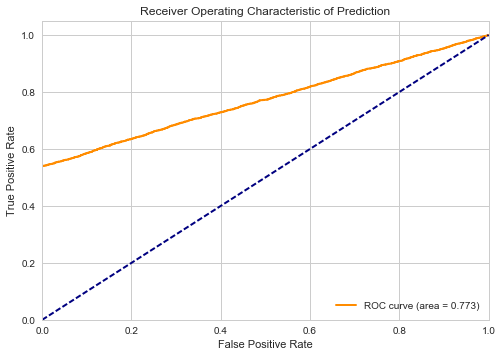

In [274]:
# Look at the ROC of just using length of time between transactions by itself. 
tm = np.array(x_ts['time_diff']).tolist()
tm_neg = [-i for i in tm]
fpr, tpr, thresholds = skl.metrics.roc_curve(y_true=y_ts, y_score=tm_neg)
auc = skl.metrics.auc(fpr, tpr)
print 'AUC=', auc

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Prediction')
plt.legend(loc="lower right")
plt.show()

In [275]:
cl_pred = mod.predict(x_ts) # The prediction, already binarized by the chosen default cutoff 
# Print number of true negatives (tn), true positives (tp), false negatives (fn), and false positives (fp)
dats = zip(cl_pred, np.array(y_ts))
ser = pd.Series([tuple(i) for i in dats])
print 'Num of tn, tp, fn, and fp (in order):\n', ser.value_counts()

Num of tn, tp, fn, and fp (in order):
(0, 0)    34178
(1, 1)     1933
(0, 1)     1652
(1, 0)       15
dtype: int64


In [280]:
## This is not super great. Are there other features that inform anything??
# Look @ country = none to make sure it isn't informative itself. 
cnty_none = []
for i in fraud['country']:
    if i == 'none':
        cnty_none.append(1)
    else:
        cnty_none.append(0)
    
dats_country_none = zip(cnty_none, np.array(fraud['class']))
ser = pd.Series([tuple(i) for i in dats_country_none])
print 'Num of tn, tp, fn, and fp (in order):\n', ser.value_counts()

Num of tn, tp, fn, and fp (in order):
(0, 0)    116878
(1, 0)     20083
(0, 1)     12268
(1, 1)      1883
dtype: int64


In [13]:
## It doesn't appear to be. 
# Is the original time important? 
# Specifically, is there a periodicity in frequency of fraudulent transactions over time?
st_fr, pt_fr, st_no, pt_no = [], [], [], []
for i in range(fraud.shape[0]):
    if fraud.iloc[i]['class'] == 1:
        st_fr.append(dt.datetime.strptime(fraud.iloc[i]['signup_time'], '%Y-%m-%d %H:%M:%S'))
        pt_fr.append(dt.datetime.strptime(fraud.iloc[i]['purchase_time'], '%Y-%m-%d %H:%M:%S'))
    else:
        st_no.append(dt.datetime.strptime(fraud.iloc[i]['signup_time'], '%Y-%m-%d %H:%M:%S'))
        pt_no.append(dt.datetime.strptime(fraud.iloc[i]['purchase_time'], '%Y-%m-%d %H:%M:%S'))


14151 136961 14151 136961


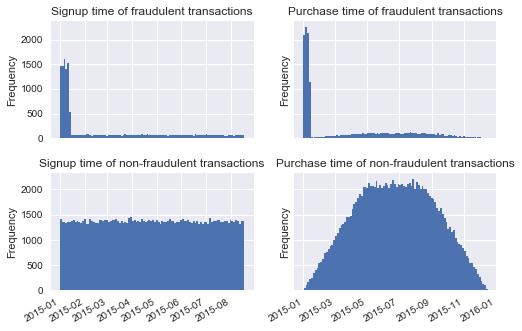

In [14]:
## Plot frequency of dates split up into fraudulent versus non-fraudulent. 
print len(st_fr), len(st_no), len(pt_fr), len(pt_no)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
ax1.hist(st_fr, bins = 100)
ax1.set_title("Signup time of fraudulent transactions")
ax1.set_ylabel("Frequency")
ax2.hist(pt_fr, bins = 100)
ax2.set_title("Purchase time of fraudulent transactions")
ax2.set_ylabel("Frequency")
ax3.hist(st_no, bins = 100)
ax3.set_title("Signup time of non-fraudulent transactions")
ax3.set_ylabel("Frequency")
ax4.hist(pt_no, bins = 100)
ax4.set_title("Purchase time of non-fraudulent transactions")
ax4.set_ylabel("Frequency")
f.subplots_adjust(hspace=0.3)
f.autofmt_xdate()
plt.show()

### It's clear that the majority of fraudulent transactions had both signup and first purchase in January. 
It's also clear that this is generated data. =P 

Let's simply add the epoch times for signup to our original dataframe to see if that helps our random forest classifier. 

In [15]:
st = []
for i in range(fraud.shape[0]):
    # Convert signup time to epoch time by subtracting the number of seconds between time and Jan 1, 1970
    st.append((dt.datetime.strptime(fraud.iloc[i]['signup_time'], '%Y-%m-%d %H:%M:%S') - 
          dt.datetime(1970,1,1)).total_seconds())

In [16]:
# Add it to fraud and prepare data for new RF
x['signup'] = pd.Series(st, index=x.index)
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=.25)
print 'There are ' + str(len(y_tr)) + ' samples in the training set and ' + str(len(y_ts)) + ' in the test set.'
x.head()

There are 113334 samples in the training set and 37778 in the test set.


,purchase_value,age,time_diff,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,...,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,country_none,signup
0,34,39,4506682.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1.424819e+09
1,16,53,17944.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1.433710e+09
2,15,53,1.0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.420138e+09
3,44,41,492085.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.430256e+09
4,39,45,4361461.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.437463e+09


### Fit new RF

In [287]:
# Build model. 
mod2 = e.RandomForestClassifier(n_estimators=5000, class_weight='balanced', oob_score=True, n_jobs=-1)
mod2.fit(x_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [288]:
# Look at the model accuracies using intrinsic decision points. 
print 'The OOB accuracy for the training set is ' + str(mod2.oob_score_)
print 'The accuracy for the test set is ' + str(mod2.score(x_ts, y_ts))

The OOB accuracy for the training set is 0.956456138493
The accuracy for the test set is 0.957170840172


AUC= 0.971186346095


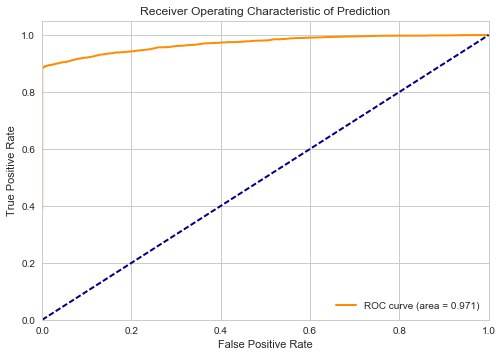

In [333]:
# Accuracy is approximately the same. How did it do for AUC?
# Compute roc curve and auc. 
p = plot_roc(mod2, x_ts, y_ts)
p.show()

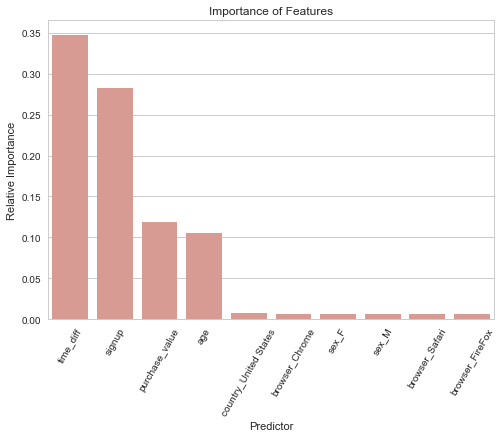

In [332]:
# Barely better. Huh... 
# Extract importances again
g = imp_graph(model=mod2, cols=x.columns)
g.show()

### Somehow we're missing something important. 
What if we go back to something that had to be removed in order to run? For example, device ID. How many unique device IDs are there in the fraud category versus non-fraudulent?

In [17]:
ids_fr, ids_no = [], []
for i in range(fraud.shape[0]):
    if fraud.iloc[i]['class'] == 1:
        ids_fr.append(fraud.iloc[i]['device_id'])
    else:
        ids_no.append(fraud.iloc[i]['device_id'])


In [18]:
print 'Unique device IDs represent ' + str(100*len(np.unique(ids_fr))/len(ids_fr)) + '% of fraudulent transactions'
print 'Unique device IDs represent ' + str(100*len(np.unique(ids_no))/len(ids_no)) + '% of non-fraudulent transactions'

Unique device IDs represent 49% of fraudulent transactions
Unique device IDs represent 97% of non-fraudulent transactions


### AHA! There you are, you little bugger. Transactions from device IDs that are duplicated may inform a lot of the remaining fraud signal. 

In [19]:
# Count the number of devices and input back into our x. 
hist = fraud.device_id.value_counts()
cts = fraud.device_id.map(lambda i: hist[i])
x['device_cts'] = cts

In [20]:
# Last random forest classifier with this data included. 
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size=.25)
# Build model. 
mod3 = e.RandomForestClassifier(n_estimators=5000, class_weight='balanced', oob_score=True, n_jobs=-1)
mod3.fit(x_tr, y_tr)
# Look at the model accuracies using intrinsic decision points. 
print 'The OOB accuracy for the training set is ' + str(mod3.oob_score_)
print 'The accuracy for the test set is ' + str(mod3.score(x_ts, y_ts))

The OOB accuracy for the training set is 0.956579667178
The accuracy for the test set is 0.95611202287


AUC= 0.840782871981


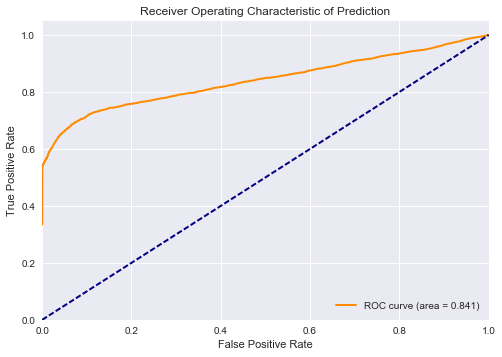

In [23]:
# Accuracy is approximately the same. How did it do for AUC?
# Compute roc curve and auc. 
p = plot_roc(mod3, x_ts, y_ts)
p.show()

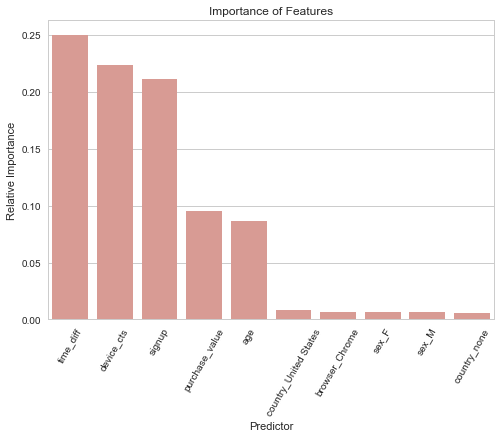

In [25]:
# Extract importances again
g = imp_graph(model=mod3, cols=x.columns)
g.show()

### There we go, that's far better, although we still can't get greater than about a 70% recall without sacrificing accuracy very dramatically. 
This indicates that there is a subset of fraudulent users that are hiding quite well. Perhaps they don't have the same device ID but they have the same IP for some reason? In either case, this is a good place to stop. 